# Imperfect tests

This model includes the sensitivity and specificity of the diagnostic test. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta,  \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\    
  \end{aligned}  
\end{equation}

where $a^p, a^s, a^e, b^p, b^s, b^e \in \mathbb{R}_{++}$ are fixed hyperparameters.
This model does not include prior knowledge about the correlation between specificity and sensitivity. 


In [1]:
import numpy as np
import pystan as ps
from scipy.special import logit, expit
from scipy.stats import beta as betadist

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan code 

Below we can see the code written in Stan. 

In [3]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/imperfect_test.stan')
    with open('../models/primary_model/pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)
        
sm_per = pickle.load(open('../models/primary_model/pickles/perfect_test.pkl', 'rb'))

Below wee see the required data and transformed data. 

In [4]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower=0> n_samples;
    int<lower=0> n_predictors; 
  
    int<lower=0, upper=1> Y[n_samples];
    matrix[n_samples, n_predictors] X;

    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
}
transformed data {
   matrix[n_predictors, n_predictors] sigma; 
   sigma = cholesky_decompose(Sigma);
}


And now the model and parameters

In [5]:
print(structure[2] + '}' + structure[3]+'}' + structure[4]+'}'+ structure[5]+'}') 


parameters {
    vector[n_predictors] normal_raw; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
}
transformed parameters {
    vector[n_samples] p; 
    vector[n_predictors] effects; 
    effects = mu + sigma * normal_raw;
    p = (1 - spec) + (spec + sens - 1) * inv_logit(logit(prev) + X * effects);
}
model {
    normal_raw ~ std_normal();
    prev ~ beta(alpha_p, beta_p);
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);
    Y ~ bernoulli(p);
}
generated quantities {
    vector[n_samples] theta;
    theta = inv_logit(logit(prev) + X * effects);
}


## Identifiability

In [7]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples)

# Standartization
x = 0.5 * (x - x.mean(axis=0))/x.std(axis = 0, ddof = 1)

Note that we generate $x$ in the same way as for perfect tests model tests. 

In [8]:
# Parameters we want to estimate
spec = 0.85
sens = 0.8

beta = np.array([0.1, 1.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1

# Generated quantities

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T  = ro.binomial(n = 1, p = p)

# Hyperparameters to the estimation process
alpha_s = 1
beta_s  = 1
alpha_e = 1
beta_e  = 1
alpha_p = 1
beta_p  = 1
Sigma   = np.eye(5)
mu      = np.zeros(5)

# Data for the Stan code
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "Y"            : T.flatten(),
    "X"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
}

T.mean()

0.215

How the numerical part of the problem enters the picture

In [10]:
%%time
fit_imperfect = sm.sampling(data=data, pars = ('prev', 'effects', 'spec', 'sens'), iter=8000)
summary = az.summary(fit_imperfect)

CPU times: user 1.39 s, sys: 150 ms, total: 1.54 s
Wall time: 10.8 s


Notice the very bad plots. 

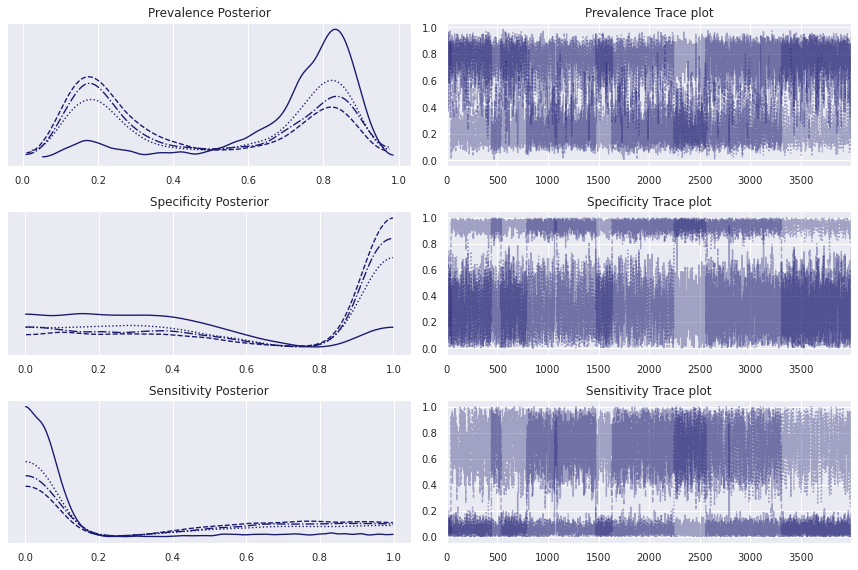

In [11]:
fig, ax = plt.subplots(3,2, figsize = (12, 8))
az.plot_trace(fit_imperfect, var_names=['prev', 'spec', 'sens'],
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', '-.', ':']},
              axes = ax
             )
ax[0,0].set_title('Prevalence Posterior')
ax[1,0].set_title('Specificity Posterior')
ax[2,0].set_title('Sensitivity Posterior')
ax[0,1].set_title('Prevalence Trace plot')
ax[1,1].set_title('Specificity Trace plot')
ax[2,1].set_title('Sensitivity Trace plot')
fig.tight_layout(pad = 1)
#plt.savefig('../images/posterior-trace-imperfect-tests-identifiability.pdf', bbox_inches='tight')
plt.show()

## Sanity check

In [6]:
def simulation(n_samples, prevalence, gamma_s, gamma_e, beta=[-0.1, 2.5, 1.4, -1.8, 0.3],
               n_pred_cont=3, n_pred_binary=2, seed=63289371):
    
    ro = np.random.RandomState(seed)
    
    n_predictors = n_pred_cont + n_pred_binary
    x = np.zeros((n_samples, n_predictors))
    x[:, :n_pred_cont] = ro.multivariate_normal(mean = np.zeros(n_pred_cont), 
                                                cov = np.eye(n_pred_cont),
                                                size = n_samples)
    x[:, :n_pred_cont] = 0.5 * (x[:, :n_pred_cont] - x[:, :n_pred_cont].mean(axis=0))/x[:, :n_pred_cont].std(axis = 0)
    x[:, n_pred_cont:] = ro.binomial(n = 1, p = [0.3, 0.7], size = (n_samples, n_pred_binary))
    
    theta = expit(logit(prevalence) + x@beta)
    p = 1-gamma_e + (gamma_e+gamma_s-1)*theta
    T = ro.binomial(n=1, p=p)
                      
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
    } 
    
    return data, theta, p

In [7]:
data, _, _ = simulation(n_samples=100, prevalence=0.1, gamma_s=0.9, gamma_e=0.8, seed=63289371)
# Prior specification
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 9,
    "beta_s"       : 1,
    "alpha_e"      : 8,
    "beta_e"       : 2,
})

In [18]:
%%time
fit_imperfect = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects'))
summary = az.summary(fit_imperfect)

CPU times: user 182 ms, sys: 44.9 ms, total: 226 ms
Wall time: 2.19 s


In [19]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.147,0.109,0.000,0.333,0.002,0.001,3553.0,4410.0,1.0
sens,0.864,0.114,0.651,1.000,0.001,0.001,5318.0,4070.0,1.0
spec,0.841,0.064,0.719,0.956,0.001,0.001,2491.0,1920.0,1.0
effects[0],0.179,0.969,-1.669,2.084,0.011,0.012,7409.0,4555.0,1.0
effects[1],2.625,1.111,0.811,4.953,0.014,0.010,6773.0,4663.0,1.0
effects[2],0.190,1.060,-1.824,2.204,0.012,0.013,7406.0,4809.0,1.0
effects[3],-1.469,1.317,-4.041,0.858,0.016,0.013,7071.0,4491.0,1.0
effects[4],0.391,1.131,-1.837,2.449,0.016,0.013,5759.0,4272.0,1.0


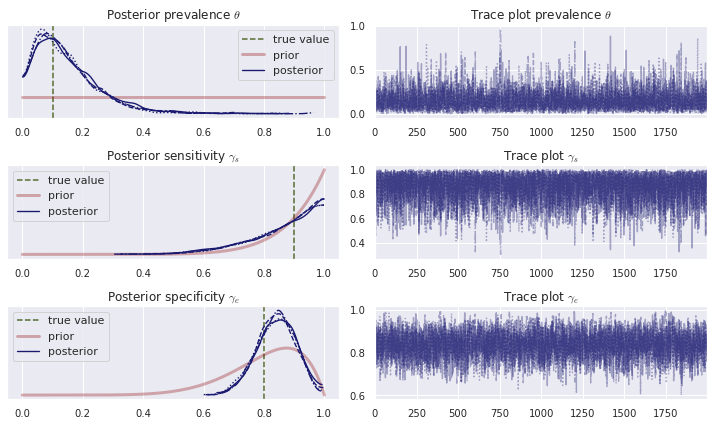

In [20]:
fig, ax = plt.subplots(3, 2, figsize = (10,6))

ax[0,0].axvline(0.1, color='darkolivegreen', linestyle='--')
ax[1,0].axvline(0.9, color='darkolivegreen', linestyle='--')
ax[2,0].axvline(0.8, color='darkolivegreen', linestyle='--')

t = np.linspace(0,1,1000)
ax[0,0].plot(t, betadist(1,1).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[1,0].plot(t, betadist(9,1).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[2,0].plot(t, betadist(8,2).pdf(t), color='darkred', alpha=0.3, linewidth=3)

az.plot_trace(fit_imperfect, var_names=['prev', 'sens', 'spec'], 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', ':', '-.']}, 
              axes=ax)

for i in range(3): ax[i,0].legend(('true value', 'prior', 'posterior'))

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior sensitivity $\gamma_s$')
ax[1,1].set_title(r'Trace plot $\gamma_s$')
ax[2,0].set_title(r'Posterior specificity $\gamma_e$')
ax[2,1].set_title(r'Trace plot $\gamma_e$')

fig.tight_layout(pad=1.0)
plt.savefig('../images/trace_plot_experiment1_imperfect_test.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
fit_perfect = sm_per.sampling(data=data, iter=4000, pars=('prev', 'effects'))
summary = az.summary(fit_perfect)

In [22]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.237,0.077,0.098,0.382,0.001,0.001,4627.0,4920.0,1.0
effects[0],0.016,0.474,-0.919,0.864,0.005,0.006,7823.0,5528.0,1.0
effects[1],1.640,0.507,0.709,2.601,0.006,0.004,6956.0,5838.0,1.0
effects[2],0.204,0.517,-0.726,1.212,0.006,0.006,7904.0,6035.0,1.0
effects[3],-0.534,0.537,-1.503,0.513,0.006,0.005,7299.0,5919.0,1.0
effects[4],0.480,0.504,-0.458,1.444,0.007,0.005,5208.0,5101.0,1.0


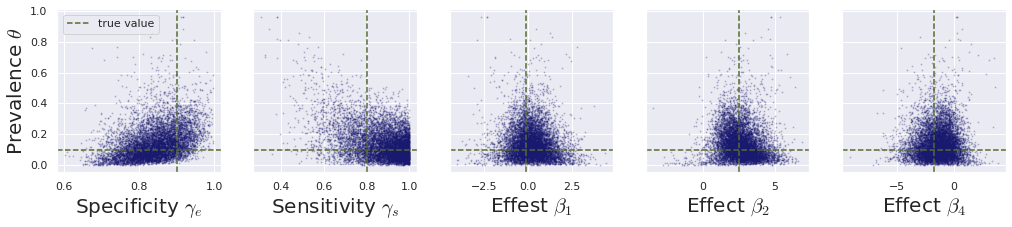

In [26]:
#az.plot_pair(fit_imperfect, var_names=['spec', 'sens', 'prev'], scatter_kwargs={'s': 1})
fig, ax = plt.subplots(1, 5, figsize=(17,3), sharey=True)
c='midnightblue'
ax[0].scatter(fit_imperfect.extract()['spec'], fit_imperfect.extract()['prev'], 
              s=1, color=c, alpha=0.2) 
ax[1].scatter(fit_imperfect.extract()['sens'], fit_imperfect.extract()['prev'], 
              s=1, color=c, alpha=0.2) 
ax[2].scatter(fit_imperfect.extract()['effects'][:,0], fit_imperfect.extract()['prev'], 
              s=1, color=c, alpha=0.2) 
ax[3].scatter(fit_imperfect.extract()['effects'][:,1], fit_imperfect.extract()['prev'], 
              s=1, color=c, alpha=0.2) 
ax[4].scatter(fit_imperfect.extract()['effects'][:,3], fit_imperfect.extract()['prev'], 
              s=1, color=c, alpha=0.2) 

ax[0].set_ylabel(r'Prevalence $\theta$', fontsize=20)
ax[0].set_xlabel(r'Specificity $\gamma_e$', fontsize=20)
ax[1].set_xlabel(r'Sensitivity $\gamma_s$', fontsize=20)
ax[2].set_xlabel(r'Effest $\beta_1$', fontsize=20)
ax[3].set_xlabel(r'Effect $\beta_2$', fontsize=20)
ax[4].set_xlabel(r'Effect $\beta_4$', fontsize=20)

ax[0].axvline(0.9, color='darkolivegreen', linestyle='--', label='true value')
ax[1].axvline(0.8, color='darkolivegreen', linestyle='--')
ax[2].axvline(-0.1, color='darkolivegreen', linestyle='--')
ax[3].axvline(2.5, color='darkolivegreen', linestyle='--')
ax[4].axvline(-1.8, color='darkolivegreen', linestyle='--')
for i in range(5): ax[i].axhline(0.1, color='darkolivegreen', linestyle='--')
ax[0].legend()

plt.savefig('../images/scatter_plot_posterior_imperfect_tests.pdf', bbox_inches = 'tight')
plt.show()

### Frequentist properties

In [125]:
counter/1000

array([0.915, 0.998, 0.83 , 0.861, 0.725, 0.801, 0.804, 0.7  ])

## Low prevalence

In [28]:
data, _, _ = simulation(n_samples=100, prevalence=0.02, gamma_s=0.85, gamma_e=0.85, seed=6312789)
# Prior specification
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 8,
    "alpha_s"      : 8,
    "beta_s"       : 2,
    "alpha_e"      : 8,
    "beta_e"       : 2,
})

data2, _, _ = simulation(n_samples=2000, prevalence=0.02, gamma_s=0.85, gamma_e=0.85, seed=6312789)
# Prior specification
data2.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 8,
    "alpha_s"      : 8,
    "beta_s"       : 2,
    "alpha_e"      : 8,
    "beta_e"       : 2,
})

In [29]:
fit_imperfect = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects'))
fit_imperfect2 = sm.sampling(data=data2, iter=4000, pars=('prev', 'sens', 'spec', 'effects'))

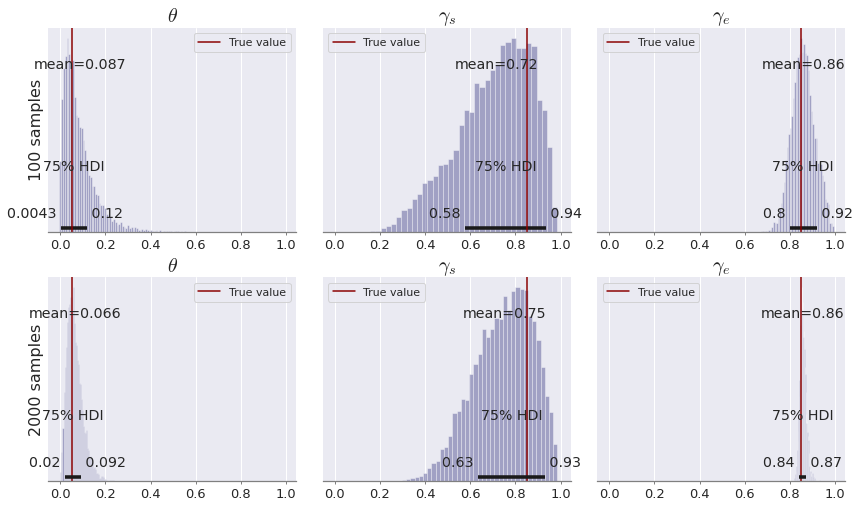

In [33]:
fig, ax = plt.subplots(2,3,figsize = (12,7), sharex=True)
az.plot_posterior(fit_imperfect, var_names=['prev', 'sens', 'spec'], ax = ax[0], kind = 'hist', 
                  hdi_prob = 0.75, color = 'midnightblue', textsize = 13)

ax[0,0].set_title(r'$\theta$', fontsize = 20)
ax[0,1].set_title(r'$\gamma_s$', fontsize = 20)
ax[0,2].set_title(r'$\gamma_e$', fontsize = 20)
    
for k, real in enumerate((0.05, 0.85, 0.85)): 
    for i in range(2): 
        ax[i,k].axvline(real, color='darkred', label='True value')
        ax[i,k].legend()
    
az.plot_posterior(fit_imperfect2, var_names=['prev', 'sens', 'spec'], ax = ax[1], kind = 'hist', 
                  hdi_prob = 0.75, color = 'midnightblue', textsize = 13)

ax[1,0].set_title(r'$\theta$', fontsize = 20)
ax[1,1].set_title(r'$\gamma_s$', fontsize = 20)
ax[1,2].set_title(r'$\gamma_e$', fontsize = 20)

ax[0,0].set_ylabel('100 samples', fontsize=16)
ax[1,0].set_ylabel('2000 samples', fontsize=16)

fig.tight_layout(pad = 0.5)
plt.savefig('../images/posterior_imperfect_tests_exp2_3.pdf', bbox_inches = 'tight')
plt.show()

## Different sensitivity and specifity 

In [125]:
data, _, p = simulation(n_samples=2000, prevalence=0.1, gamma_s=0.6, gamma_e=0.9, seed=7132892)
# Prior specification
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 8,
    "alpha_s"      : 6,
    "beta_s"       : 4,
    "alpha_e"      : 18,
    "beta_e"       : 2,
})

In [126]:
fit_imperfect = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec'))

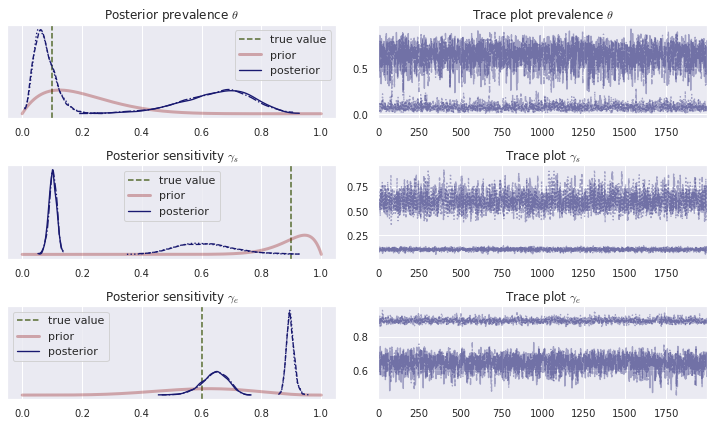

In [127]:
fig, ax = plt.subplots(3, 2, figsize = (10,6))

ax[0,0].axvline(0.1, color='darkolivegreen', linestyle='--')
ax[1,0].axvline(0.9, color='darkolivegreen', linestyle='--')
ax[2,0].axvline(0.6, color='darkolivegreen', linestyle='--')

t = np.linspace(0,1,1000)
ax[0,0].plot(t, betadist(2,8).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[1,0].plot(t, betadist(18,2).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[2,0].plot(t, betadist(6, 4).pdf(t), color='darkred', alpha=0.3, linewidth=3)

az.plot_trace(fit_imperfect, var_names=['prev', 'sens', 'spec'], 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', ':', '-.']}, 
              axes=ax)

for i in range(3): ax[i,0].legend(('true value', 'prior', 'posterior'))

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior sensitivity $\gamma_s$')
ax[1,1].set_title(r'Trace plot $\gamma_s$')
ax[2,0].set_title(r'Posterior sensitivity $\gamma_e$')
ax[2,1].set_title(r'Trace plot $\gamma_e$')

fig.tight_layout(pad=1.0)
#plt.savefig('../images/trace_plot_experiment4_imperfect_test.pdf', bbox_inches = 'tight')
plt.show()

In [128]:
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 8,
    "alpha_s"      : 120,
    "beta_s"       : 80,
    "alpha_e"      : 18,
    "beta_e"       : 2,
})
fit_imperfect = sm.sampling(data=data, warmup=3000, iter=4000, chains=4, pars=('prev', 'sens', 'spec'))

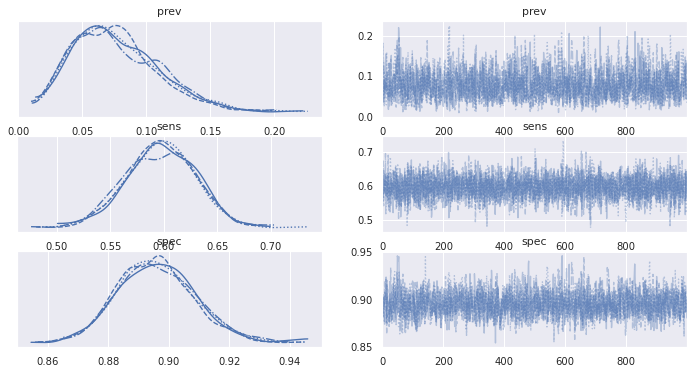

In [129]:
az.plot_trace(fit_imperfect)
plt.show()

## A high prevalence

In [158]:
data, _, p = simulation(n_samples=500, prevalence=0.45, gamma_s=0.9, gamma_e=0.8, seed=7132892)
# Prior specification
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 2,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 16,
    "beta_e"       : 4,
})

In [159]:
fit_imperfect = sm.sampling(data=data, warmup=3000, iter=5000, chains=4, pars=('prev', 'sens', 'spec'))

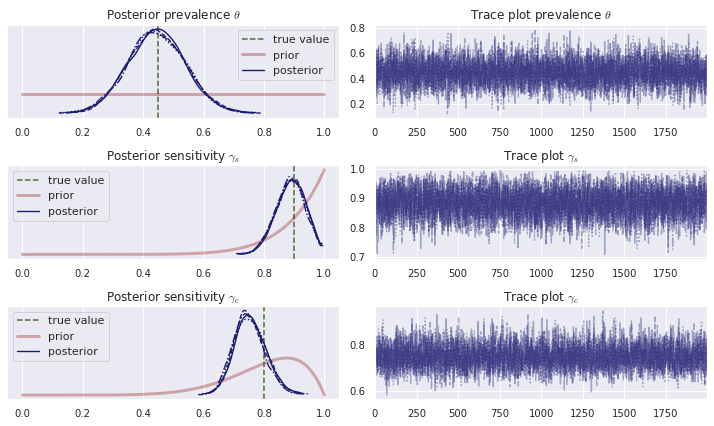

In [160]:
fig, ax = plt.subplots(3, 2, figsize = (10,6))

ax[0,0].axvline(0.45, color='darkolivegreen', linestyle='--')
ax[1,0].axvline(0.9, color='darkolivegreen', linestyle='--')
ax[2,0].axvline(0.8, color='darkolivegreen', linestyle='--')

t = np.linspace(0,1,1000)
ax[0,0].plot(t, betadist(1, 1).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[1,0].plot(t, betadist(9, 1).pdf(t), color='darkred', alpha=0.3, linewidth=3)
ax[2,0].plot(t, betadist(8, 2).pdf(t), color='darkred', alpha=0.3, linewidth=3)

az.plot_trace(fit_imperfect, var_names=['prev', 'sens', 'spec'], 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', ':', '-.']}, 
              axes=ax)

for i in range(3): ax[i,0].legend(('true value', 'prior', 'posterior'))

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior sensitivity $\gamma_s$')
ax[1,1].set_title(r'Trace plot $\gamma_s$')
ax[2,0].set_title(r'Posterior sensitivity $\gamma_e$')
ax[2,1].set_title(r'Trace plot $\gamma_e$')

fig.tight_layout(pad=1.0)
#plt.savefig('../images/trace_plot_experiment4_imperfect_test.pdf', bbox_inches = 'tight')
plt.show()